In [289]:
#Basic Libs
import pandas as pd

import numpy as np


# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score,classification_report, precision_score

from sklearn.decomposition import PCA  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

#warnings
import warnings

warnings.filterwarnings("ignore")

# Data Mining

In [290]:
data = pd.read_excel("/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/data/Songs_2024.xlsx", sheet_name= 1)
data1 = data.copy().dropna()
data1.shape



(2299, 19)

In [291]:
#dealing w/year
data1['track_age_2024'] =  data1['year'].map(lambda x: 2024-x)

#dealing w/genres
import re
#check number of unique sub_genres
genres_list = []
for genres_str in data1["artist_genres"]:
    cleaned_str = re.sub(r"[\[\]']", "", genres_str)
    genres = cleaned_str.split(';')
    for genre in genres:
        genres_list.append(genre.strip())

len(set(genres_list))

438

In [292]:
#dealing the genres
# Convert 'artist_genres' from string representation of a list to an actual list
# The genres are separated by ';', so we split on this character
data1['artist_genres'] = data1['artist_genres'].apply(lambda x: x.strip("[]").replace("'", "").split("; "))

# Define the genre mapping

mapping = {
    "pop": ['pop', 'pop punk', 'dance pop', 'europop', 'girl group', 'pop rap', 'bahamian pop', 'canadian pop', 'pop dance', 'post-teen pop', 'boy band', 'art pop', 'metropopolis', 'barbadian pop', 'viral pop', 'candy pop', 'australian pop', 'folk-pop', 'k-pop', 'bubblegum dance', 'pop dance'],
    "rock": ['permanent wave', 'alternative metal', 'modern rock', 'punk', 'rock', 'socal pop punk', 'alternative rock', 'dance rock', 'pop rock', 'celtic rock', 'irish rock', 'grunge', 'uk pop', 'neo mellow', 'piano rock', 'pov: indie', 'modern alternative rock', 'neon pop punk', 'garage rock', 'indie rock', 'canadian rock', 'british invasion', 'emo','neo-psychedelic','screamo','glam metal','beatlesque','madchester','supergroup'],
    "country": ['contemporary country', 'country', 'country dawn', 'country road'],
    "hip_hop_rap": ['detroit hip hop', 'hip hop', 'rap', 'dirty south rap', 'hip pop', 'east coast hip hop', 'hardcore hip hop', 'gangster rap', 'west coast rap', 'st louis rap', 'trap', 'southern hip hop', 'atl hip hop', 'melodic rap', 'miami hip hop', 'chicago rap', 'canadian hip hop', 'old school atlanta hip hop', 'queens hip hop', 'crunk', 'conscious hip hop', 'trap queen', 'south carolina hip hop', 'new orleans rap', 'G Funk','brooklyn drill','hyphy','atlanta bass'],
    "rnb_soul": ['contemporary r&b', 'r&b', 'urban contemporary', 'british soul', 'neo soul', 'pop soul', 'canadian contemporary r&b','soul','pluggnb'],
    "house_and_pop_fusion" : ['disco house', 'filter house', 'bouncy house', 'electro house', 'slap house', 'tropical house', 'pop dance', 'house', 'progressive house', 'indietronica', 'progressive electro house', 'uk garage', 'big room', 'complextro'],
    "underground_electronic" : ['electro', 'big beat', 'downtempo', 'melbourne bounce international', 'electro trash', 'grave wave', 'dark clubbing', 'ukg revival', 'hardcore techno', 'grime', 'instrumental grime', 'dancefloor dnb', 'trance', 'speed garage','new wave','bounce','handsup','chicago hardcore','rave','german techno','hamburg electronic','happy hardcore', 'industrial','techno'],
    "metal": ['nu metal', 'post-grunge', 'rap metal', 'funk metal', 'industrial metal'],
    "jazz": ['jazz', 'smooth jazz', 'bebop', 'swing', 'fusion jazz', 'stomp and holler'],
    "classical": ['classical', 'baroque', 'romantic', 'symphony', 'opera'],
    "reggae": ['reggae', 'dancehall', 'reggae fusion', 'dub', 'roots reggae','moombahton'],
    "latin": ['latin', 'reggaeton', 'latin pop', 'salsa', 'bachata', 'merengue', 'tango', 'cumbia', 'trap latino', 'urbano latino', 'mexican pop', 'colombian pop', 'mambo chileno','urbano chileno', 'tropical'],
    "singer-songwriter": ['singer-songwriter pop', 'singer-songwriter'],
    "folk":['folk','classic schlager', 'oktoberfest', 'schlager', 'celtic','middle earth','sertanejo','sertanejo universitario'],
    "talent show": ['talent show']
}

# Flatten the mapping for easier access
flat_mapping = {}
for main_genre, subgenres in mapping.items():
    for subgenre in subgenres:
        flat_mapping[subgenre] = main_genre

# Function to categorize genres
def categorize_genres(genres_list, mapping):
    genre_counts = {}
    for genre in genres_list:
        for subgenre, main_genre in mapping.items():
            if subgenre in genre:
                genre_counts[main_genre] = genre_counts.get(main_genre, 0) + 1
    if genre_counts:
        # Return the most frequent main genre, if tie, sorted order decides
        return max(genre_counts, key=genre_counts.get)
    else:
        return "other"  # or "other" if you prefer to label unmatched genres as "other"

# Apply the categorization function
data1['dominant_genre'] = data1['artist_genres'].apply(lambda x: categorize_genres(x, flat_mapping))


In [293]:
#dealing with keys
# Define the mapping dictionary for music keys
key_mapping = {0.: 'C',1.: 'C#',2.: 'D',3: 'D#',4.: 'E',5.: 'F',6.: 'F#',7.: 'G',8.: 'G#',9.: 'A',10.: 'A#',11.: 'B'}

data1['key'] = data1['key'].map(key_mapping)

#dealing w/mode
tone = {0 : 'min', 1: 'Maj'}
data1['mode'] = data1['mode'].map(tone)

#create tonality
data1['tonality'] = data1['key'] + data1['mode']


# Bining Target Variable


In [294]:
def categorize_song4(popularity):
    if popularity < 60:
        return 0 #'Niche'
    elif 60 <= popularity < 80:
        return 1 #'Moderate'
    elif 80 <= popularity < 90:
        return 2 #'Popular'
    else:  # This covers popularity >= 90
        return 3 #'Hit'


def categorize_song3(popularity):
    if popularity < 60:
        return 0 #Niche
    elif 60 <= popularity < 85:
        return 1 #Moderate
    else:  # This covers popularity >= 90
        return 2 #popular
    
#switch function to different cat
data1['song_popularity_labels'] = data1.apply(
    lambda x: categorize_song3(x['track_popularity']), axis=1)

In [295]:
print(data.shape)
print(data1.shape)
print(data1.columns)

(2300, 19)
(2299, 23)
Index(['year', 'track_name', 'track_popularity', 'album', 'artist_name',
       'artist_genres', 'artist_popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'track_age_2024',
       'dominant_genre', 'tonality', 'song_popularity_labels'],
      dtype='object')


In [296]:
data1.dtypes

year                        int64
track_name                 object
track_popularity            int64
album                      object
artist_name                object
artist_genres              object
artist_popularity           int64
danceability              float64
energy                    float64
key                        object
loudness                  float64
mode                       object
speechiness               float64
acousticness              float64
instrumentalness          float64
liveness                  float64
valence                   float64
tempo                     float64
duration_ms               float64
track_age_2024              int64
dominant_genre             object
tonality                   object
song_popularity_labels      int64
dtype: object

# One Hot Encoding

In [297]:
#dummified dominant_genre
# Perform one-hot encoding
data1 = pd.get_dummies(data1, columns=['dominant_genre'], prefix_sep="_",prefix="genre",dtype=int)
# Drop a specific column
data1 = data1.drop('genre_talent show', axis=1)
print(sum(data1.columns.str.contains("genre_") == True))

#dummified tonality
data1 = pd.get_dummies(data1, columns=['tonality'],prefix_sep="_",prefix="tone",drop_first=True, dtype=int)
print(sum(data1.columns.str.contains('tone_')))

14
23


# Dimension Reduction (PCA) for Audio Features

In [298]:
audio_features = ['danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms']

pca_data = data1[audio_features]

ss = StandardScaler().fit(pca_data)
X_std = ss.transform(pca_data)

sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

VARIANCE_TO_KEEP = 0.75
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
retained_components_number = keep_recommend

sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

data1_PCA = pd.concat([data1, pd.DataFrame(Y_sklearn_final[:, :5], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])], axis=1)
data1_PCA.rename(columns={'PC1': 'PC1_Energetic_Dynamic', 'PC2': 'PC2_Speech_Tempo', 'PC3': 'PC3_Acoustic_Speech', 'PC4': 'PC4_Duration_Mood ', 'PC5': 'PC5_Acoustic_Liveness'}, inplace=True)
data1_PCA.head()

Number of components to keep to retain 75.0% of the variance: 5 out of the original 10


,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,...,tone_Fmin,tone_G#Maj,tone_G#min,tone_GMaj,tone_Gmin,PC1_Energetic_Dynamic,PC2_Speech_Tempo,PC3_Acoustic_Speech,PC4_Duration_Mood,PC5_Acoustic_Liveness
0,2000.0,Yellow,91.0,Parachutes,Coldplay,"[permanent wave, pop]",86.0,0.429,0.661,B,...,0.0,0.0,0.0,0.0,0.0,0.697489,2.681419,-0.475313,0.575820,0.265080
1,2000.0,All The Small Things,84.0,Enema Of The State,blink-182,"[alternative metal, modern rock, pop punk, pun...",75.0,0.434,0.897,C,...,0.0,0.0,0.0,0.0,0.0,-1.863289,2.037136,-0.917177,0.337012,-0.962087
2,2000.0,Breathe,69.0,Breathe,Faith Hill,"[contemporary country, country, country dawn, ...",61.0,0.529,0.496,G,...,0.0,0.0,0.0,1.0,0.0,1.955014,1.289486,-0.361391,-0.056666,0.118168
3,2000.0,In the End,88.0,Hybrid Theory (Bonus Edition),Linkin Park,"[alternative metal, nu metal, post-grunge, rap...",83.0,0.556,0.864,D#,...,0.0,0.0,0.0,0.0,0.0,-0.464720,0.915760,0.304314,-0.611131,0.001659
4,2000.0,Bye Bye Bye,74.0,No Strings Attached,*NSYNC,"[boy band, dance pop, pop]",65.0,0.610,0.926,G#,...,0.0,0.0,1.0,0.0,0.0,-1.901801,0.609784,0.664915,1.312768,-0.747559


In [299]:
data1_PCA = data1_PCA.rename_axis("song_id")
data1_PCA.head()

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,...,tone_Fmin,tone_G#Maj,tone_G#min,tone_GMaj,tone_Gmin,PC1_Energetic_Dynamic,PC2_Speech_Tempo,PC3_Acoustic_Speech,PC4_Duration_Mood,PC5_Acoustic_Liveness
song_id,,,,,,,,,,,,,,,,,,,,,
0,2000.0,Yellow,91.0,Parachutes,Coldplay,"[permanent wave, pop]",86.0,0.429,0.661,B,...,0.0,0.0,0.0,0.0,0.0,0.697489,2.681419,-0.475313,0.575820,0.265080
1,2000.0,All The Small Things,84.0,Enema Of The State,blink-182,"[alternative metal, modern rock, pop punk, pun...",75.0,0.434,0.897,C,...,0.0,0.0,0.0,0.0,0.0,-1.863289,2.037136,-0.917177,0.337012,-0.962087
2,2000.0,Breathe,69.0,Breathe,Faith Hill,"[contemporary country, country, country dawn, ...",61.0,0.529,0.496,G,...,0.0,0.0,0.0,1.0,0.0,1.955014,1.289486,-0.361391,-0.056666,0.118168
3,2000.0,In the End,88.0,Hybrid Theory (Bonus Edition),Linkin Park,"[alternative metal, nu metal, post-grunge, rap...",83.0,0.556,0.864,D#,...,0.0,0.0,0.0,0.0,0.0,-0.464720,0.915760,0.304314,-0.611131,0.001659
4,2000.0,Bye Bye Bye,74.0,No Strings Attached,*NSYNC,"[boy band, dance pop, pop]",65.0,0.610,0.926,G#,...,0.0,0.0,1.0,0.0,0.0,-1.901801,0.609784,0.664915,1.312768,-0.747559


In [300]:
#rename index
data1_PCA = data1_PCA.rename_axis("song_id")
data1_PCA.columns

Index(['year', 'track_name', 'track_popularity', 'album', 'artist_name',
       'artist_genres', 'artist_popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'track_age_2024',
       'song_popularity_labels', 'genre_country', 'genre_folk',
       'genre_hip_hop_rap', 'genre_house_and_pop_fusion', 'genre_jazz',
       'genre_latin', 'genre_metal', 'genre_other', 'genre_pop',
       'genre_reggae', 'genre_rnb_soul', 'genre_rock',
       'genre_singer-songwriter', 'genre_underground_electronic', 'tone_A#min',
       'tone_AMaj', 'tone_Amin', 'tone_BMaj', 'tone_Bmin', 'tone_C#Maj',
       'tone_C#min', 'tone_CMaj', 'tone_Cmin', 'tone_D#Maj', 'tone_D#min',
       'tone_DMaj', 'tone_Dmin', 'tone_EMaj', 'tone_Emin', 'tone_F#Maj',
       'tone_F#min', 'tone_FMaj', 'tone_Fmin', 'tone_G#Maj', 'tone_G#min',
       'tone_GMaj', 'tone_Gmin', 'PC1_Energetic_Dynamic', 'PC2_Spee

In [301]:
print(data1_PCA.dtypes)

year                     float64
track_name                object
track_popularity         float64
album                     object
artist_name               object
                          ...   
PC1_Energetic_Dynamic    float64
PC2_Speech_Tempo         float64
PC3_Acoustic_Speech      float64
PC4_Duration_Mood        float64
PC5_Acoustic_Liveness    float64
Length: 63, dtype: object


In [302]:
# download data in csv
data1_PCA.to_csv("/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/data/modeling/data_cleaned_final_PCA.csv")

# Starting Checking the Model

In [303]:
tlabel3 = "/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/data/data_cleaned_3lab.xlsx"
tlabel3_PCA = "/Users/lucazosso/Desktop/IE_Course/Term_2/Machine Learning II/Group Assignement/data/modeling/data_cleaned_final_PCA.csv"

### Data Loading

In [304]:
data = pd.read_csv(tlabel3_PCA,index_col="song_id")
cols_to_drop = ['year', 'track_name', 'track_popularity', 'album', 'artist_name',
       'artist_genres', 'mode', 'key']
data = data.drop(columns = cols_to_drop)
data.columns

Index(['artist_popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'track_age_2024',
       'song_popularity_labels', 'genre_country', 'genre_folk',
       'genre_hip_hop_rap', 'genre_house_and_pop_fusion', 'genre_jazz',
       'genre_latin', 'genre_metal', 'genre_other', 'genre_pop',
       'genre_reggae', 'genre_rnb_soul', 'genre_rock',
       'genre_singer-songwriter', 'genre_underground_electronic', 'tone_A#min',
       'tone_AMaj', 'tone_Amin', 'tone_BMaj', 'tone_Bmin', 'tone_C#Maj',
       'tone_C#min', 'tone_CMaj', 'tone_Cmin', 'tone_D#Maj', 'tone_D#min',
       'tone_DMaj', 'tone_Dmin', 'tone_EMaj', 'tone_Emin', 'tone_F#Maj',
       'tone_F#min', 'tone_FMaj', 'tone_Fmin', 'tone_G#Maj', 'tone_G#min',
       'tone_GMaj', 'tone_Gmin', 'PC1_Energetic_Dynamic', 'PC2_Speech_Tempo',
       'PC3_Acoustic_Speech', 'PC4_Duration_Mood ', 'PC5_Acoustic_Liveness'],
      dtype='obj

In [305]:
data.dtypes

artist_popularity               float64
danceability                    float64
energy                          float64
loudness                        float64
speechiness                     float64
acousticness                    float64
instrumentalness                float64
liveness                        float64
valence                         float64
tempo                           float64
duration_ms                     float64
track_age_2024                  float64
song_popularity_labels          float64
genre_country                   float64
genre_folk                      float64
genre_hip_hop_rap               float64
genre_house_and_pop_fusion      float64
genre_jazz                      float64
genre_latin                     float64
genre_metal                     float64
genre_other                     float64
genre_pop                       float64
genre_reggae                    float64
genre_rnb_soul                  float64
genre_rock                      float64


In [306]:
df = data.copy()
#drop 2 null rows ==> TO BE CHECKED
df.drop(index=[2299,447], inplace=True)

rand_seed = 477
acc="accuracy" # our metric for Grid Searching

PCA_Data = df.drop(columns=audio_features)
Data = df.loc[:, ~df.columns.str.contains('PC_')]



In [307]:
def split_df(dataframe, seed=None ,percentage=0.8):
    
    X = dataframe.loc[:, dataframe.columns != 'song_popularity_labels']
    y = dataframe['song_popularity_labels']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed, stratify=y) # note the stratify parameter

# MODELING STARTS HERE

## Logistics Regressions

Wo/PCA

In [343]:

from sklearn.linear_model import LogisticRegression

# train_test_split
X_train, X_test, Y_train, Y_test = split_df(Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)


log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)
predictions = log_reg.predict(X_test)
class_report = classification_report(Y_test, predictions)

f1_Log = f1_score(Y_test,predictions, average='weighted')
precision_Log = precision_score(Y_test, predictions, average='weighted')
recall_Log = recall_score(Y_test, predictions, average='weighted')

print(class_report)

Number of explanatories:  54
              precision    recall  f1-score   support

         0.0       1.00      0.04      0.07        81
         1.0       0.81      1.00      0.90       558
         2.0       0.00      0.00      0.00        51

    accuracy                           0.81       690
   macro avg       0.60      0.35      0.32       690
weighted avg       0.77      0.81      0.73       690



W/PCA

In [344]:

# train_test_split
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)


log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)
predictions = log_reg.predict(X_test)
class_report_PCA_Logit = classification_report(Y_test, predictions)

f1_Log_PCA = f1_score(Y_test,predictions, average='weighted')
precision_Log_PCA = precision_score(Y_test, predictions, average='weighted')
recall_Log_PCA = recall_score(Y_test, predictions, average='weighted')


print(class_report_PCA_Logit)

Number of explanatories:  54
              precision    recall  f1-score   support

         0.0       0.75      0.07      0.13        81
         1.0       0.82      0.99      0.90       558
         2.0       0.00      0.00      0.00        51

    accuracy                           0.81       690
   macro avg       0.52      0.36      0.34       690
weighted avg       0.75      0.81      0.74       690



## Decision Tree

In [345]:

# train_test_split
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

decision_tree = DecisionTreeClassifier() # by default Gini index, no random replication
decision_tree.fit(X_train, Y_train)
predictions = decision_tree.predict(X_test)
accDT=accuracy_score(Y_test, predictions)
print("Accuracy test set Decision Trees (not pruned) = {0:.2%}".format(accDT))

f1_Tree = f1_score(Y_test,predictions, average='weighted')
precision_Tree = precision_score(Y_test, predictions, average='weighted')
recall_Tree = recall_score(Y_test, predictions, average='weighted')

class_report_Decision_Tree = classification_report(Y_test, predictions)
print(class_report_Decision_Tree)


Number of explanatories:  54
Accuracy test set Decision Trees (not pruned) = 72.90%
              precision    recall  f1-score   support

         0.0       0.27      0.31      0.29        81
         1.0       0.84      0.84      0.84       558
         2.0       0.20      0.16      0.18        51

    accuracy                           0.73       690
   macro avg       0.44      0.44      0.44       690
weighted avg       0.73      0.73      0.73       690



In [346]:

#with GRID SEARCH

# train_test_split
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

param_grid = {
    'max_depth': range(1,16)
    } 

tree_grid = GridSearchCV(decision_tree, param_grid, scoring=acc, cv=5 , n_jobs=1, verbose=1)
tree_grid.fit(X_train,Y_train)
print("Best param: ", tree_grid.best_params_)
tree_pruned = DecisionTreeClassifier(max_depth=tree_grid.best_params_["max_depth"], criterion="entropy")
tree_pruned.fit(X_train, Y_train)
predictions = tree_pruned.predict(X_test)
accDTGrid=accuracy_score(Y_test, predictions)
print("Accuracy of Test set (pruned) = {0:.2%}".format(accDTGrid))

f1_TreeGrid = f1_score(Y_test,predictions, average='weighted')
precision_TreeGrid = precision_score(Y_test, predictions, average='weighted')
recall_TreeGrid = recall_score(Y_test, predictions, average='weighted')

class_report_Decision_Tree_Grid = classification_report(Y_test, predictions)
print(class_report_Decision_Tree_Grid)


Number of explanatories:  54
Fitting 5 folds for each of 15 candidates, totalling 75 fits


Best param:  {'max_depth': 1}
Accuracy of Test set (pruned) = 80.87%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        81
         1.0       0.81      1.00      0.89       558
         2.0       0.00      0.00      0.00        51

    accuracy                           0.81       690
   macro avg       0.27      0.33      0.30       690
weighted avg       0.65      0.81      0.72       690



## Bagging

In [347]:

# train_test_split
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

bagging = RandomForestClassifier(n_estimators=200, oob_score=True) # no max_features option=Bagging
bagging.fit(X_train, Y_train)
predictions = bagging.predict(X_test)
accBagg=bagging.oob_score_
print("Accuracy OOB set - Bagging = {0:.2%}".format(accBagg))

f1_Bagg = f1_score(Y_test,predictions, average='weighted')
precision_Bagg = precision_score(Y_test, predictions, average='weighted')
recall_Bagg = recall_score(Y_test, predictions, average='weighted')

class_report_Bagging = classification_report(Y_test, predictions)
print(class_report_Bagging)

Number of explanatories:  54
Accuracy OOB set - Bagging = 80.91%
              precision    recall  f1-score   support

         0.0       0.67      0.10      0.17        81
         1.0       0.82      0.99      0.90       558
         2.0       0.50      0.02      0.04        51

    accuracy                           0.81       690
   macro avg       0.66      0.37      0.37       690
weighted avg       0.78      0.81      0.75       690



In [348]:

#with GRID SEARCH

# train_test_split
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

param_grid = {'min_samples_leaf' :[3,4,5,6,7]}

BaggGrid = GridSearchCV(bagging, param_grid=param_grid, cv=5, scoring=acc, verbose=2) 
BaggGrid.fit(X_train,Y_train)
print("Best param: ", BaggGrid.best_params_)
model = RandomForestClassifier(n_estimators = 200, oob_score = True,
                               min_samples_leaf = BaggGrid.best_params_["min_samples_leaf"])
model.fit(X_train,Y_train)
predictions = model.predict(X_test)
accBaggGrid=model.oob_score_
print("Accuracy OOB set - Bagging with Grid Searching: {0:.2%}".format(accBaggGrid))

f1_BaggGrid = f1_score(Y_test,predictions, average='weighted')
precision_BaggGrid = precision_score(Y_test, predictions, average='weighted')
recall_BaggGrid = recall_score(Y_test, predictions, average='weighted')

class_report_Bagging_Grid = classification_report(Y_test, predictions)
print(class_report_Bagging_Grid)

Number of explanatories:  54
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=3; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=4; total time=   0.4s
[CV] END .................................min_samples_leaf=5; total time=   0.4s
[CV] END ...........

## Random Forest

In [349]:

# train_test_split
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

RandomForest = RandomForestClassifier(n_estimators=200, oob_score=True, max_features=8) # 62 explanatories
RandomForest.fit(X_train, Y_train)
accRF=RandomForest.oob_score_
print("Accuracy OOB set Random Forests = {0:.2%}".format(accRF))

predictions = RandomForest.predict(X_test)

f1_RF = f1_score(Y_test,predictions, average='weighted')
precision_RF = precision_score(Y_test, predictions, average='weighted')
recall_RF = recall_score(Y_test, predictions, average='weighted')

class_report_RandomForest = classification_report(Y_test, predictions)
print(class_report_Bagging_Grid)

Number of explanatories:  54
Accuracy OOB set Random Forests = 81.28%
              precision    recall  f1-score   support

         0.0       0.60      0.04      0.07        81
         1.0       0.81      1.00      0.89       558
         2.0       0.00      0.00      0.00        51

    accuracy                           0.81       690
   macro avg       0.47      0.34      0.32       690
weighted avg       0.73      0.81      0.73       690



In [350]:

#with Grid search
# train_test_split
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

param_grid = {
    'min_samples_leaf' :[3,4,5,6], 
    'max_features' : [10,15,20,25,30],
}

RFGrid = GridSearchCV(RandomForest, param_grid=param_grid, cv=5, scoring=acc, verbose=2) 
RFGrid.fit(X_train,Y_train)
print("Best param: ", RFGrid.best_params_)
model = RandomForestClassifier(n_estimators=200, oob_score=True, 
                               max_features=RFGrid.best_params_["max_features"], 
                               min_samples_leaf=RFGrid.best_params_["min_samples_leaf"])
model.fit(X_train,Y_train)
accRFGrid=model.oob_score_
print("Accuracy OOB set - RF with Grid Searching: {0:.2%}".format(accRFGrid))

predictions = model.predict(X_test)


f1_RFGrid = f1_score(Y_test,predictions, average='weighted')
precision_RFGrid = precision_score(Y_test, predictions, average='weighted')
recall_RFGrid = recall_score(Y_test, predictions, average='weighted')

class_report_RandomForest_Grid = classification_report(Y_test, predictions)
print(class_report_RandomForest_Grid)



Number of explanatories:  54
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best param:  {'max_features': 10, 'min_samples_leaf': 6}
Accuracy OOB set - RF with Grid Searching: 81.22%
              precision    recall  f1-score   support

         0.0       0.62      0.06      0.11        81
         1.0       0.81      0.99      0.90       558
         2.0       0.00      0.00      0.00        51

    accuracy                           0.81       690
   macro avg       0.48      0.35      0.34       690
weighted avg       0.73      0.81      0.74       690



## Boosting


In [351]:

# train_test_split
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

xgb = XGBClassifier(n_estimators=200)

xgb.fit(X_train, Y_train)
predictions_XGBC = xgb.predict(X_test)
accBoost = accuracy_score(predictions_XGBC, Y_test)
print("Accuracy test set of XGBClassifier: {0:.2%}".format(accBoost))


f1_Boost = f1_score(Y_test,predictions, average='weighted')
precision_Boost = precision_score(Y_test, predictions, average='weighted')
recall_Boost = recall_score(Y_test, predictions, average='weighted')

class_report_XGBOOST = classification_report(Y_test, predictions_XGBC)
print(class_report_XGBOOST)

Number of explanatories:  54
Accuracy test set of XGBClassifier: 79.71%
              precision    recall  f1-score   support

         0.0       0.47      0.22      0.30        81
         1.0       0.83      0.95      0.88       558
         2.0       0.23      0.06      0.09        51

    accuracy                           0.80       690
   macro avg       0.51      0.41      0.43       690
weighted avg       0.74      0.80      0.76       690



In [352]:

# With GRID SEARCH
X_train, X_test, Y_train, Y_test = split_df(PCA_Data, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

params = {
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7], 
        'learning_rate': [0.001, 0.01, 0.1]
        }

xgbGrid = GridSearchCV(xgb, params, cv = 5, scoring=acc, verbose=2)
xgbGrid.fit(X_train, Y_train)
print("Best set of hyperparameters: ", xgbGrid.best_params_)

xgb_model = XGBClassifier(n_estimators=200, learning_rate=xgbGrid.best_params_["learning_rate"],
                    max_depth=xgbGrid.best_params_["max_depth"],
                    subsample=xgbGrid.best_params_["subsample"])

model.fit(X_train, Y_train)
predictions = model.predict(X_test)
accBoostGrid=accuracy_score(Y_test, predictions)
print("Accuracy test set - Boosting with Grid Searching: {0:.2%}".format(accBoostGrid))

f1_BoostGrid = f1_score(Y_test,predictions, average='weighted')
precision_BoostGrid = precision_score(Y_test, predictions, average='weighted')
recall_BoostGrid = recall_score(Y_test, predictions, average='weighted')

class_report_XGBOOST_Grid = classification_report(Y_test, predictions)
print(class_report_XGBOOST_Grid)




Number of explanatories:  54
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best set of hyperparameters:  {'learning_rate': 0.001, 'max_depth': 3, 'subsample': 1.0}
Accuracy test set - Boosting with Grid Searching: 81.01%
              precision    recall  f1-score   support

         0.0       0.60      0.04      0.07        81
         1.0       0.81      1.00      0.89       558
         2.0       0.00      0.00      0.00        51

    accuracy                           0.81       690
   macro avg       0.47      0.34      0.32       690
weighted avg       0.73      0.81      0.73       690



## KNN


In [353]:
# First Standardize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#Data = w/O PCA
#PCA_Data = PCA
#min_max_scaler = MinMaxScaler()
#data = min_max_scaler.fit_transform(data)
columns_to_scale = [col for col in PCA_Data.columns if col != 'song_popularity_labels']
standard_scaler = StandardScaler()
knndata = PCA_Data.copy()
knndata[columns_to_scale] = standard_scaler.fit_transform(knndata[columns_to_scale])


In [354]:
#Start KNN
from sklearn.neighbors import KNeighborsClassifier
#train_test_split
X_train, X_test, Y_train, Y_test = split_df(knndata, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)


Number of explanatories:  54


In [355]:
#Model 1


knn_classifier = KNeighborsClassifier(n_neighbors=5)

knn_classifier.fit(X_train, Y_train)

# Predictions (on test set, obviously)
knn_predictions = knn_classifier.predict(X_test)

# Calculate error_rate
acc_KNN_M1 = accuracy_score(Y_test, knn_predictions)
error_rate = 1 - accuracy_score(Y_test, knn_predictions)
print("Error (k=5): {0:.2%}".format(error_rate))

f1_KNN_M1 = f1_score(Y_test,predictions, average='weighted')
precision_KNN_M1 = precision_score(Y_test, predictions, average='weighted')
recall_KNN_M1 = recall_score(Y_test, predictions, average='weighted')

class_report_KNN_m1 = classification_report(Y_test, knn_predictions)
print(class_report_KNN_m1)

Error (k=5): 19.86%
              precision    recall  f1-score   support

         0.0       0.33      0.06      0.10        81
         1.0       0.81      0.98      0.89       558
         2.0       0.50      0.02      0.04        51

    accuracy                           0.80       690
   macro avg       0.55      0.35      0.34       690
weighted avg       0.73      0.80      0.73       690



In [356]:
#Model 2 w/ grid Search

X_train, X_test, Y_train, Y_test = split_df(knndata, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)

parameters = {
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"]
}
knn_Grid_M2 = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, verbose=2)
knn_Grid_M2 .fit(X_train, Y_train)
print("Best parameters: ", knn_Grid_M2 .best_params_)

train_preds_grid = knn_Grid_M2 .predict(X_train)
predictions = knn_Grid_M2 .predict(X_test)

Number of explanatories:  54
Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .........

In [357]:
knn_classifier_M2 = KNeighborsClassifier(n_neighbors=knn_Grid_M2.best_params_['n_neighbors'],weights=knn_Grid_M2.best_params_['weights'])

knn_classifier_M2.fit(X_train, Y_train)

# Predictions (on test set, obviously)
knn_predictions_M2 = knn_classifier_M2.predict(X_test)

# Calculate error_rate
acc_KNN_M2 = accuracy_score(Y_test, knn_predictions_M2)
error_rate_M2 = 1 - accuracy_score(Y_test, knn_predictions_M2)
print("Error (k=5): {0:.2%}".format(error_rate_M2))

f1_KNN_M2 = f1_score(Y_test,knn_predictions_M2, average='weighted')
precision_KNN_M2 = precision_score(Y_test, knn_predictions_M2, average='weighted')
recall_KNN_M2 = recall_score(Y_test, knn_predictions_M2, average='weighted')

class_report_KNN_M2 = classification_report(Y_test, knn_predictions_M2)
print(class_report_KNN_M2)

Error (k=5): 18.99%
              precision    recall  f1-score   support

         0.0       1.00      0.01      0.02        81
         1.0       0.81      1.00      0.89       558
         2.0       0.00      0.00      0.00        51

    accuracy                           0.81       690
   macro avg       0.60      0.34      0.31       690
weighted avg       0.77      0.81      0.73       690



In [358]:
train_preds_grid = knn_Grid_M2.predict(X_train)
predictions = knn_Grid_M2.predict(X_test)

## SMOTE

In [364]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

#train test split
X_train, X_test, Y_train, Y_test = split_df(knndata, seed=rand_seed, percentage=0.7)
print("Number of explanatories: ", len(Data.columns)-1)


# First, find the smallest class size
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(Y_train)
min_class_size = np.min(np.bincount(encoded_labels))
k_neighbors = max(1, min(3, min_class_size - 1))  # Ensure at least 1

# Applying SMOTE to the training set with adjusted k_neighbors
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)

Number of explanatories:  54


<Axes: title={'center': 'Class distribution after appying SMOTE'}, xlabel='song_pop_labels'>

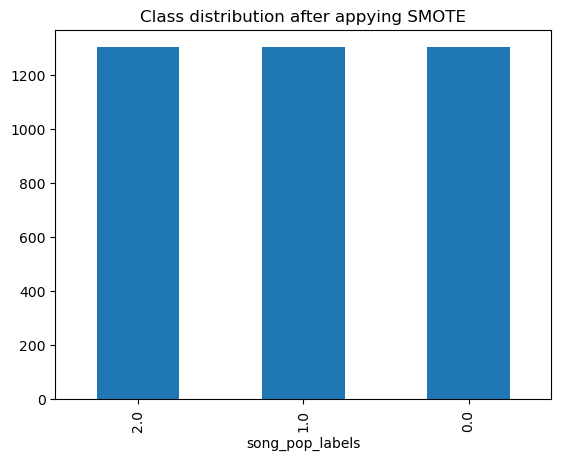

In [365]:
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE', xlabel='song_pop_labels')

In [ ]:
#Logistic

# DT

# Bagging

# RF

# Boosting






log_reg_2.fit(X_resampled, y_resampled)

# EVALUATION THE MODELS


In [359]:
class_report_variables = [var for var in globals() if var.startswith("class_report")]
print(class_report_variables)


['class_report', 'class_report_PCA_Logit', 'class_report_Decision_Tree', 'class_report_Decision_Tree_Grid', 'class_report_Bagging', 'class_report_Bagging_Grid', 'class_report_RandomForest', 'class_report_RandomForest_Grid', 'class_report_XGBOOST', 'class_report_XGBOOST_Grid', 'class_report_KNN_m1', 'class_report_variables', 'class_report_KNN_M2']


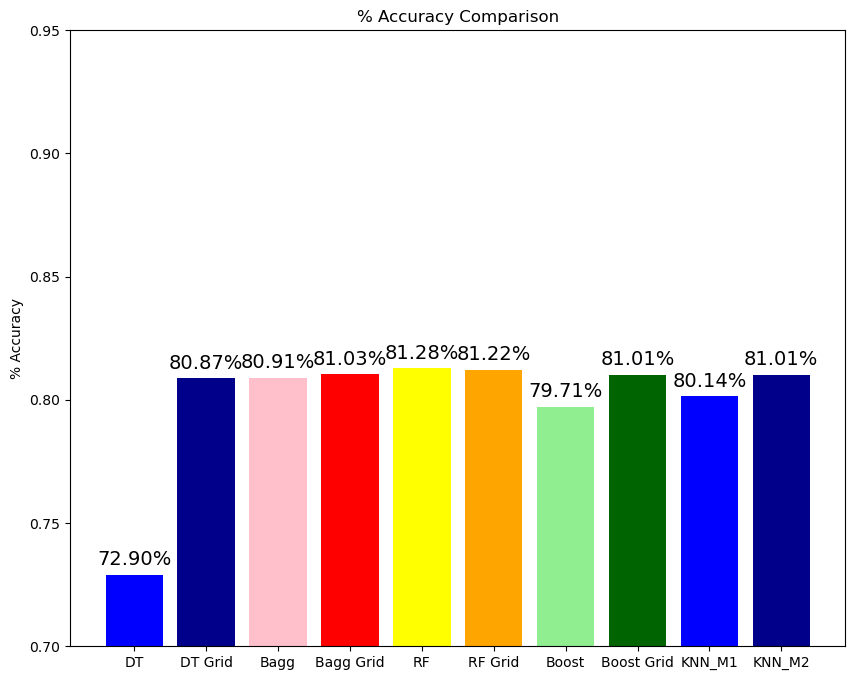

In [360]:
categ = ['DT', 'DT Grid', 'Bagg', 'Bagg Grid', 'RF', 'RF Grid', 'Boost', 'Boost Grid', 'KNN_M1', 'KNN_M2']
values = [accDT, accDTGrid, accBagg, accBaggGrid, accRF, accRFGrid, accBoost, accBoostGrid,acc_KNN_M1, acc_KNN_M2]
colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen'] 

plt.figure(figsize=(10,8))
plt.bar(categ, values, color=colors)
plt.ylim(.70, .95)

plt.xlabel('')
plt.ylabel('% Accuracy')
plt.title('% Accuracy Comparison')

for i, v in enumerate(values):
    plt.text(i, v+0.01, "{0:.2%}".format(v) , ha='center', va='top', fontsize=14)
    
plt.show()

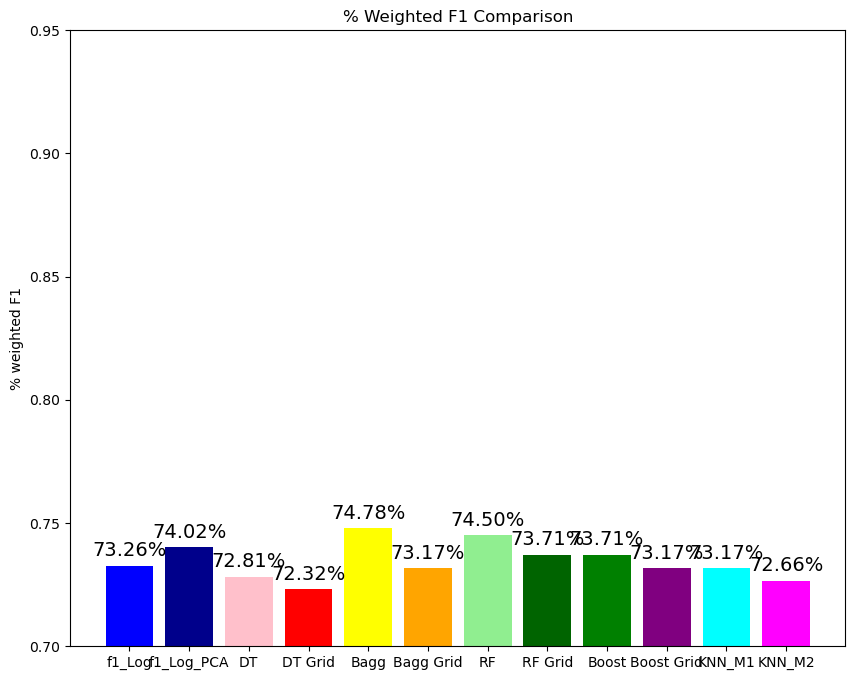

In [361]:
categ = ['f1_Log','f1_Log_PCA','DT', 'DT Grid', 'Bagg', 'Bagg Grid', 'RF', 'RF Grid', 'Boost', 'Boost Grid','KNN_M1','KNN_M2']
values = [f1_Log,f1_Log_PCA,f1_Tree,f1_TreeGrid, f1_Bagg, f1_BaggGrid, f1_RF, f1_RFGrid, f1_Boost, f1_BoostGrid, f1_KNN_M1, f1_KNN_M2]
colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen', 'green','purple','cyan', 'magenta'] 

plt.figure(figsize=(10,8))
plt.bar(categ, values, color=colors)
plt.ylim(.70, .95)

plt.xlabel('')
plt.ylabel('% weighted F1')
plt.title('% Weighted F1 Comparison')

for i, v in enumerate(values):
    plt.text(i, v+0.01, "{0:.2%}".format(v) , ha='center', va='top', fontsize=14)
    
plt.show()

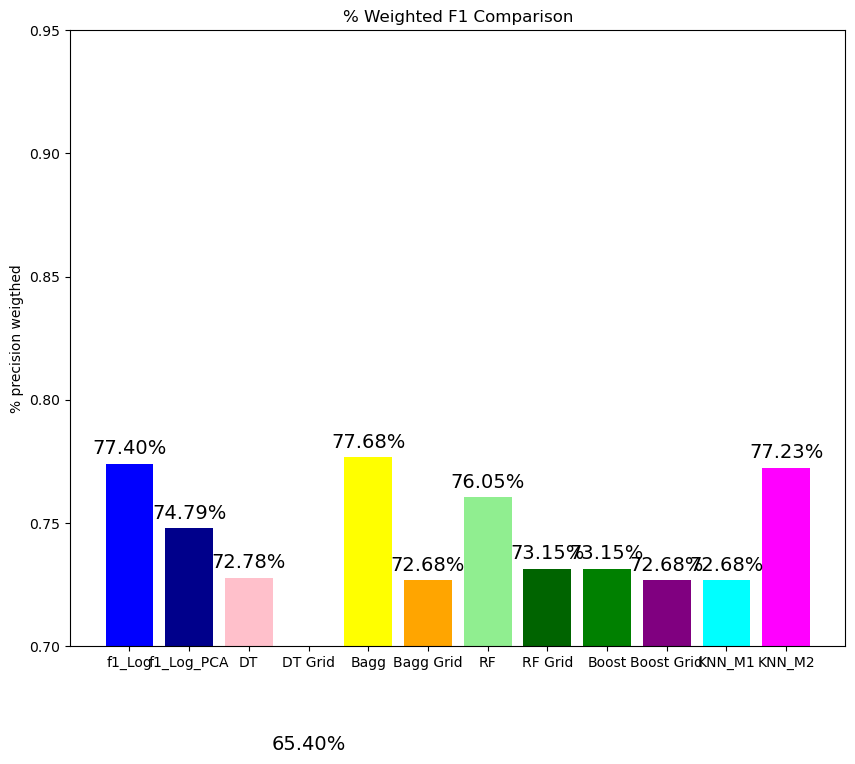

In [362]:
categ = ['f1_Log','f1_Log_PCA','DT', 'DT Grid', 'Bagg', 'Bagg Grid', 'RF', 'RF Grid', 'Boost', 'Boost Grid','KNN_M1', 'KNN_M2']
values = [precision_Log,precision_Log_PCA,precision_Tree,precision_TreeGrid, precision_Bagg, precision_BaggGrid, precision_RF, precision_RFGrid, precision_Boost, precision_BoostGrid, precision_KNN_M1, precision_KNN_M2]
colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen', 'green','purple','cyan', 'magenta'] 

plt.figure(figsize=(10,8))
plt.bar(categ, values, color=colors)
plt.ylim(.70, .95)

plt.xlabel('')
plt.ylabel('% precision weigthed')
plt.title('% Weighted F1 Comparison')

for i, v in enumerate(values):
    plt.text(i, v+0.01, "{0:.2%}".format(v) , ha='center', va='top', fontsize=14)
    
plt.show()

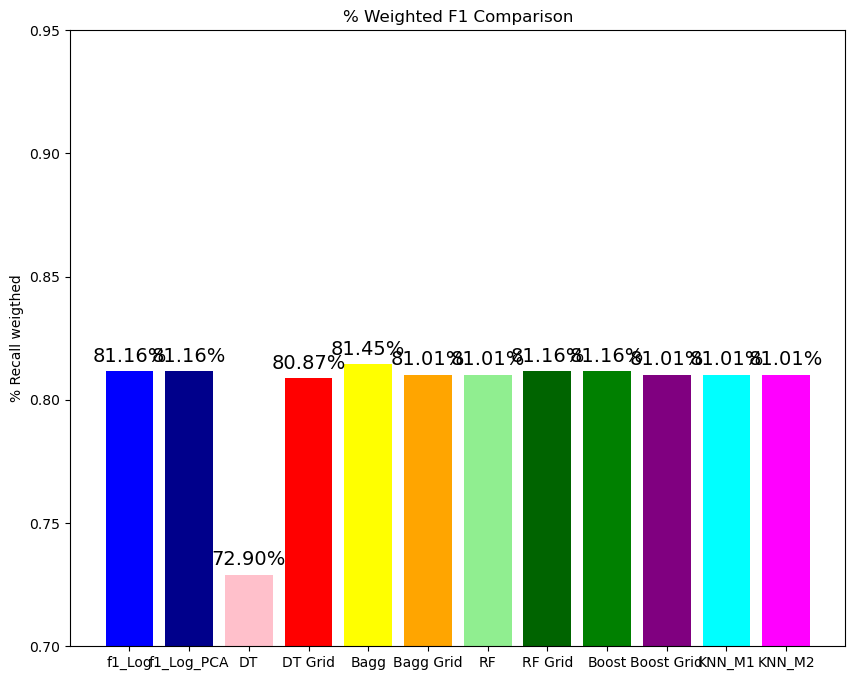

In [363]:
categ = ['f1_Log','f1_Log_PCA','DT', 'DT Grid', 'Bagg', 'Bagg Grid', 'RF', 'RF Grid', 'Boost', 'Boost Grid','KNN_M1', 'KNN_M2']
values = [recall_Log,recall_Log_PCA,recall_Tree,recall_TreeGrid, recall_Bagg, recall_BaggGrid, recall_RF, recall_RFGrid, recall_Boost, recall_BoostGrid, recall_KNN_M1, recall_KNN_M2]
colors = ['blue', 'darkblue', 'pink', 'red', 'yellow', 'orange', 'lightgreen', 'darkgreen', 'green','purple','cyan', 'magenta'] 

plt.figure(figsize=(10,8))
plt.bar(categ, values, color=colors)
plt.ylim(.70, .95)

plt.xlabel('')
plt.ylabel('% Recall weigthed')
plt.title('% Weighted F1 Comparison')

for i, v in enumerate(values):
    plt.text(i, v+0.01, "{0:.2%}".format(v) , ha='center', va='top', fontsize=14)
    
plt.show()